# 🔢 Handwritten Digit Recognition using CNN

In [ ]:
cd "/content/drive/My Drive/Machine Learning/CNN-MNIST Digit"

/content/drive/My Drive/Machine Learning/CNN-MNIST Digit


## 🔽 Downloading MNIST Data

In [ ]:
from requests import get
from io import BytesIO
import numpy as np

data_response = get("https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz")
data_response.raise_for_status()

with np.load(BytesIO(data_response.content)) as arrays:
        train_images, train_labels = arrays['x_train'], arrays['y_train']
        test_images, test_labels = arrays['x_test'], arrays['y_test']

In [ ]:
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0

## 🔎 Exploring Data

Visualizing some handwritten digits

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", color_codes=True)
sns.set(font_scale=1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def draw_image(image, title=None):
    plt.imshow(image, cmap="binary")
    plt.grid(False)
    plt.xticks(())
    if title:
        plt.xlabel(title, color="black")
    plt.yticks(())

In [ ]:
from random import randint

numberwise_samples = {}

while True:
    selected_index = randint(0, train_labels.shape[0])
    if train_labels[selected_index] not in numberwise_samples:
        numberwise_samples[train_labels[selected_index]] = selected_index
        if all(index in numberwise_samples for index in range(10)):
            break

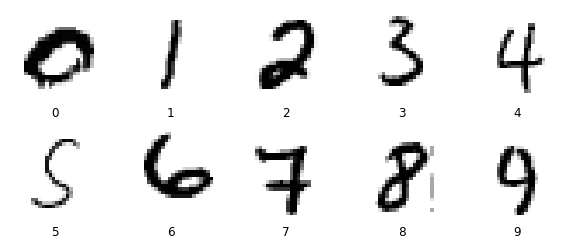

In [ ]:
fig = plt.figure(figsize=(2*5, 2*2))

for i in range(10):
    plt.subplot(2,5,i+1)
    draw_image(train_images[numberwise_samples[i]].reshape((28,28)), str(i))

plt.show()

In [ ]:
train_images = train_images.reshape((-1, 28, 28, 1))
test_images = test_images.reshape((-1, 28, 28, 1))

## 🙃 Data Augmentation

Generating slight variations of the existing data to increase the versatility of the models.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=3,
    height_shift_range=3,
    shear_range=0.1
)

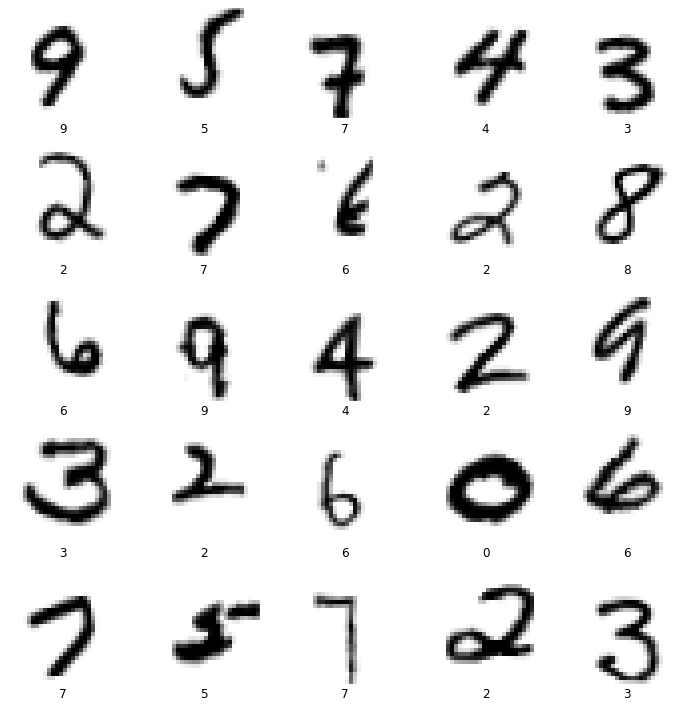

In [ ]:
n=5

x, y = datagen.flow(train_images, train_labels, batch_size=n*n).next()
fig = plt.figure(figsize=(2*n, 2*n))

for i in range(n*n):
    plt.subplot(n,n,i+1)
    draw_image(x[i].reshape(28,28), str(y[i]))

fig.tight_layout()
plt.show()

In [ ]:
block_title = """
--------------------------------------------------
{}
--------------------------------------------------
"""

def print_title(title):
    print(block_title.format(title))

## 🧠 Model Designing

3 pairs of Convolutional Layers with increasing number of filters and decreasing resolution using stride 2 Convolutional Layers followed by a Flatten Layer, a Dense Layer and an output Dense Layer, with Dropout Layers in between to ensure every part of the network gets trained.

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, Flatten, Dense

def make_model():
    model = Sequential([
        Conv2D(32, 3, padding='same', activation='relu', input_shape=(28,28,1)),
        Conv2D(32, 3, padding='same', activation='relu'),

        Dropout(0.4),

        Conv2D(32, 5, strides=2, padding='same', activation='relu'),

        Conv2D(64, 3, padding='same', activation='relu'),
        Conv2D(64, 3, padding='same', activation='relu'),

        Dropout(0.4),

        Conv2D(64, 5, strides=2, padding='same', activation='relu'),

        Conv2D(128, 3, padding='same', activation='relu'),
        Conv2D(128, 3, padding='same', activation='relu'),

        Dropout(0.4),

        Flatten(),

        Dense(32, activation='relu'),

        Dropout(0.4),

        Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()
    print("\n")

    return model

In [ ]:
n_models = 5
models = [make_model() for _ in range(n_models)]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        25632     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0

## 💡 Model Training

In [ ]:
MODELS_FOLDER_PATH = 'models'

LR_REDUCE_FACTOR = 0.75
LR_REDUCE_PATIENCE = 4
LR_REDUCE_MIN_DELTA = 1e-4
LR_REDUCE_MIN_LR = 1e-6

EPOCHS = 75
BATCH_SIZE = 500

In [ ]:
from pathlib import Path
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

models_folder = Path(MODELS_FOLDER_PATH)
models_folder.mkdir(exist_ok=True)

def make_callbacks(model_name):
    return [
        ReduceLROnPlateau(
            monitor='val_loss', 
            factor=LR_REDUCE_FACTOR, 
            patience=LR_REDUCE_PATIENCE,
            mode='min', 
            min_delta=LR_REDUCE_MIN_DELTA,
            min_lr=LR_REDUCE_MIN_LR
        ),
        ModelCheckpoint(
            models_folder / f"{model_name}.h5",
            save_best_only=True                
        )
    ]

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def train_model(model, model_name):
    new_train_images, val_images, new_train_labels, val_labels = train_test_split(train_images, train_labels, test_size = 0.1)

    history = pd.DataFrame(model.fit(
        datagen.flow(new_train_images, new_train_labels, batch_size=BATCH_SIZE),
        validation_data=(val_images, val_labels),
        epochs=EPOCHS,
        verbose=1,
        callbacks=make_callbacks(model_name)
    ).history)

    plt.figure(figsize=(15,6))

    plt.subplot(1,2,1)
    sns.lineplot(data=history[["accuracy", "val_accuracy"]])

    plt.subplot(1,2,2)
    sns.lineplot(data=history[["loss", "val_loss"]])

    plt.show()

    return history


--------------------------------------------------
Model 1
--------------------------------------------------

Epoch 1/75
108/108 [==============================] - 16s 151ms/step - loss: 0.9044 - accuracy: 0.6937 - val_loss: 0.0926 - val_accuracy: 0.9740
Epoch 2/75
108/108 [==============================] - 16s 149ms/step - loss: 0.2687 - accuracy: 0.9219 - val_loss: 0.0601 - val_accuracy: 0.9815
Epoch 3/75
108/108 [==============================] - 16s 147ms/step - loss: 0.1897 - accuracy: 0.9458 - val_loss: 0.0521 - val_accuracy: 0.9842
Epoch 4/75
108/108 [==============================] - 16s 149ms/step - loss: 0.1401 - accuracy: 0.9602 - val_loss: 0.0433 - val_accuracy: 0.9882
Epoch 5/75
108/108 [==============================] - 16s 148ms/step - loss: 0.1115 - accuracy: 0.9695 - val_loss: 0.0369 - val_accuracy: 0.9898
Epoch 6/75
108/108 [==============================] - 16s 146ms/step - loss: 0.0956 - accuracy: 0.9748 - val_loss: 0.0341 - val_accuracy: 0.9908
Epoch 7/75
108/108

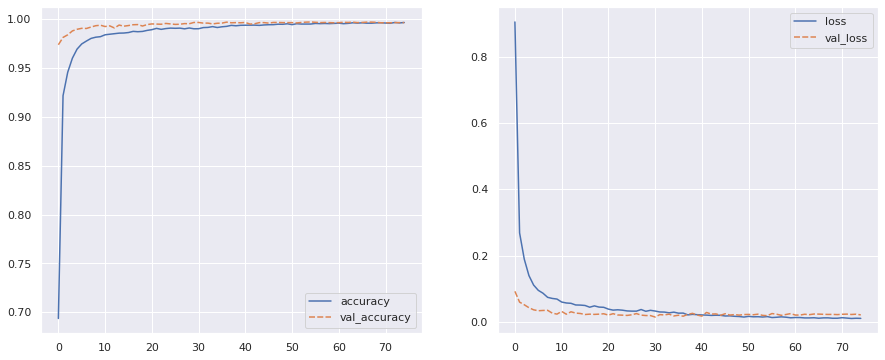


--------------------------------------------------
Model 2
--------------------------------------------------

Epoch 1/75
108/108 [==============================] - 16s 144ms/step - loss: 0.9860 - accuracy: 0.6644 - val_loss: 0.1150 - val_accuracy: 0.9695
Epoch 2/75
108/108 [==============================] - 15s 140ms/step - loss: 0.2796 - accuracy: 0.9171 - val_loss: 0.0710 - val_accuracy: 0.9818
Epoch 3/75
108/108 [==============================] - 15s 142ms/step - loss: 0.1912 - accuracy: 0.9458 - val_loss: 0.0544 - val_accuracy: 0.9868
Epoch 4/75
108/108 [==============================] - 14s 131ms/step - loss: 0.1456 - accuracy: 0.9586 - val_loss: 0.0722 - val_accuracy: 0.9837
Epoch 5/75
108/108 [==============================] - 15s 140ms/step - loss: 0.1199 - accuracy: 0.9674 - val_loss: 0.0388 - val_accuracy: 0.9900
Epoch 6/75
108/108 [==============================] - 14s 131ms/step - loss: 0.1023 - accuracy: 0.9712 - val_loss: 0.0420 - val_accuracy: 0.9903
Epoch 7/75
108/108

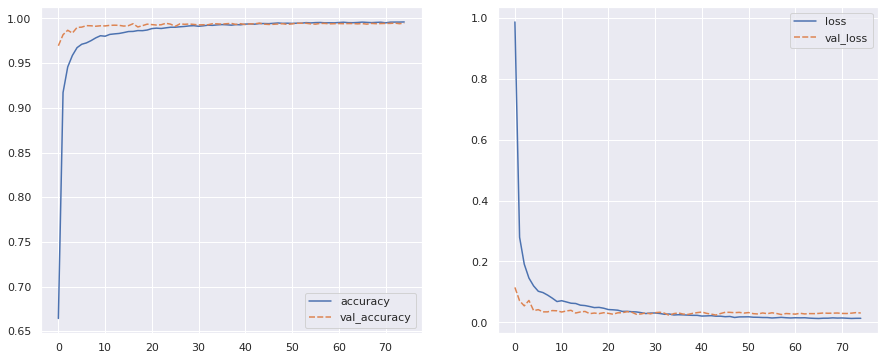


--------------------------------------------------
Model 3
--------------------------------------------------

Epoch 1/75
108/108 [==============================] - 15s 143ms/step - loss: 0.9685 - accuracy: 0.6696 - val_loss: 0.1193 - val_accuracy: 0.9672
Epoch 2/75
108/108 [==============================] - 15s 139ms/step - loss: 0.2732 - accuracy: 0.9202 - val_loss: 0.0834 - val_accuracy: 0.9787
Epoch 3/75
108/108 [==============================] - 16s 144ms/step - loss: 0.1814 - accuracy: 0.9497 - val_loss: 0.0498 - val_accuracy: 0.9865
Epoch 4/75
108/108 [==============================] - 15s 140ms/step - loss: 0.1435 - accuracy: 0.9608 - val_loss: 0.0481 - val_accuracy: 0.9867
Epoch 5/75
108/108 [==============================] - 14s 131ms/step - loss: 0.1207 - accuracy: 0.9690 - val_loss: 0.0519 - val_accuracy: 0.9860
Epoch 6/75
108/108 [==============================] - 15s 140ms/step - loss: 0.0960 - accuracy: 0.9745 - val_loss: 0.0378 - val_accuracy: 0.9903
Epoch 7/75
108/108

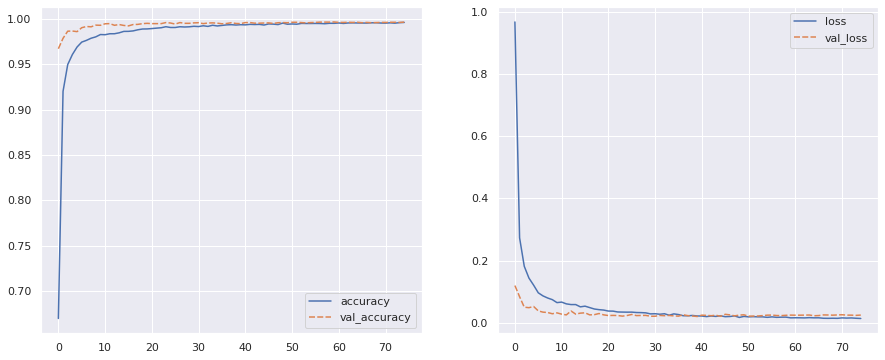


--------------------------------------------------
Model 4
--------------------------------------------------

Epoch 1/75
108/108 [==============================] - 15s 142ms/step - loss: 0.9196 - accuracy: 0.6914 - val_loss: 0.0938 - val_accuracy: 0.9698
Epoch 2/75
108/108 [==============================] - 15s 139ms/step - loss: 0.2702 - accuracy: 0.9196 - val_loss: 0.0593 - val_accuracy: 0.9815
Epoch 3/75
108/108 [==============================] - 15s 142ms/step - loss: 0.1752 - accuracy: 0.9501 - val_loss: 0.0503 - val_accuracy: 0.9872
Epoch 4/75
108/108 [==============================] - 15s 142ms/step - loss: 0.1400 - accuracy: 0.9603 - val_loss: 0.0414 - val_accuracy: 0.9895
Epoch 5/75
108/108 [==============================] - 15s 136ms/step - loss: 0.1248 - accuracy: 0.9655 - val_loss: 0.0542 - val_accuracy: 0.9872
Epoch 6/75
108/108 [==============================] - 15s 141ms/step - loss: 0.1103 - accuracy: 0.9686 - val_loss: 0.0361 - val_accuracy: 0.9905
Epoch 7/75
108/108

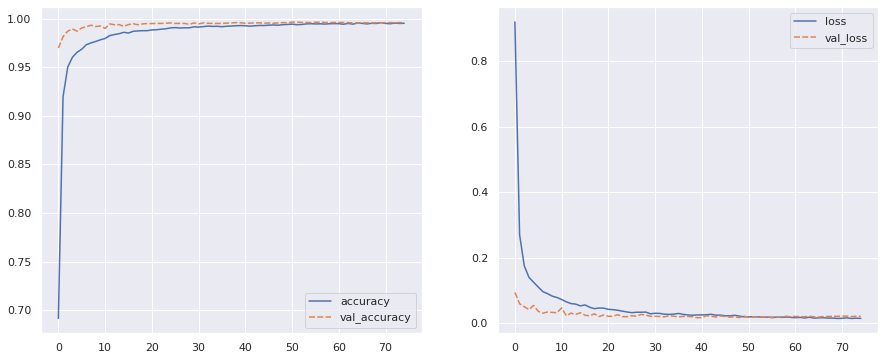


--------------------------------------------------
Model 5
--------------------------------------------------

Epoch 1/75
108/108 [==============================] - 16s 147ms/step - loss: 0.8965 - accuracy: 0.6955 - val_loss: 0.1157 - val_accuracy: 0.9647
Epoch 2/75
108/108 [==============================] - 15s 141ms/step - loss: 0.2632 - accuracy: 0.9228 - val_loss: 0.0569 - val_accuracy: 0.9843
Epoch 3/75
108/108 [==============================] - 15s 141ms/step - loss: 0.1757 - accuracy: 0.9503 - val_loss: 0.0547 - val_accuracy: 0.9865
Epoch 4/75
108/108 [==============================] - 16s 144ms/step - loss: 0.1291 - accuracy: 0.9635 - val_loss: 0.0358 - val_accuracy: 0.9903
Epoch 5/75
108/108 [==============================] - 15s 142ms/step - loss: 0.1113 - accuracy: 0.9699 - val_loss: 0.0317 - val_accuracy: 0.9907
Epoch 6/75
108/108 [==============================] - 15s 136ms/step - loss: 0.0999 - accuracy: 0.9734 - val_loss: 0.0368 - val_accuracy: 0.9898
Epoch 7/75
108/108

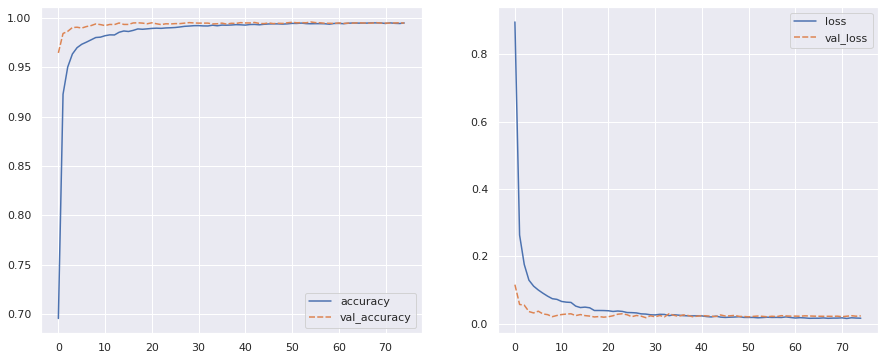

In [18]:
histories = list()

for i, model in enumerate(models):
    print_title(f"Model {i+1}")

    histories.append(train_model(model, f"mnist-digits-model-{i+1}"))

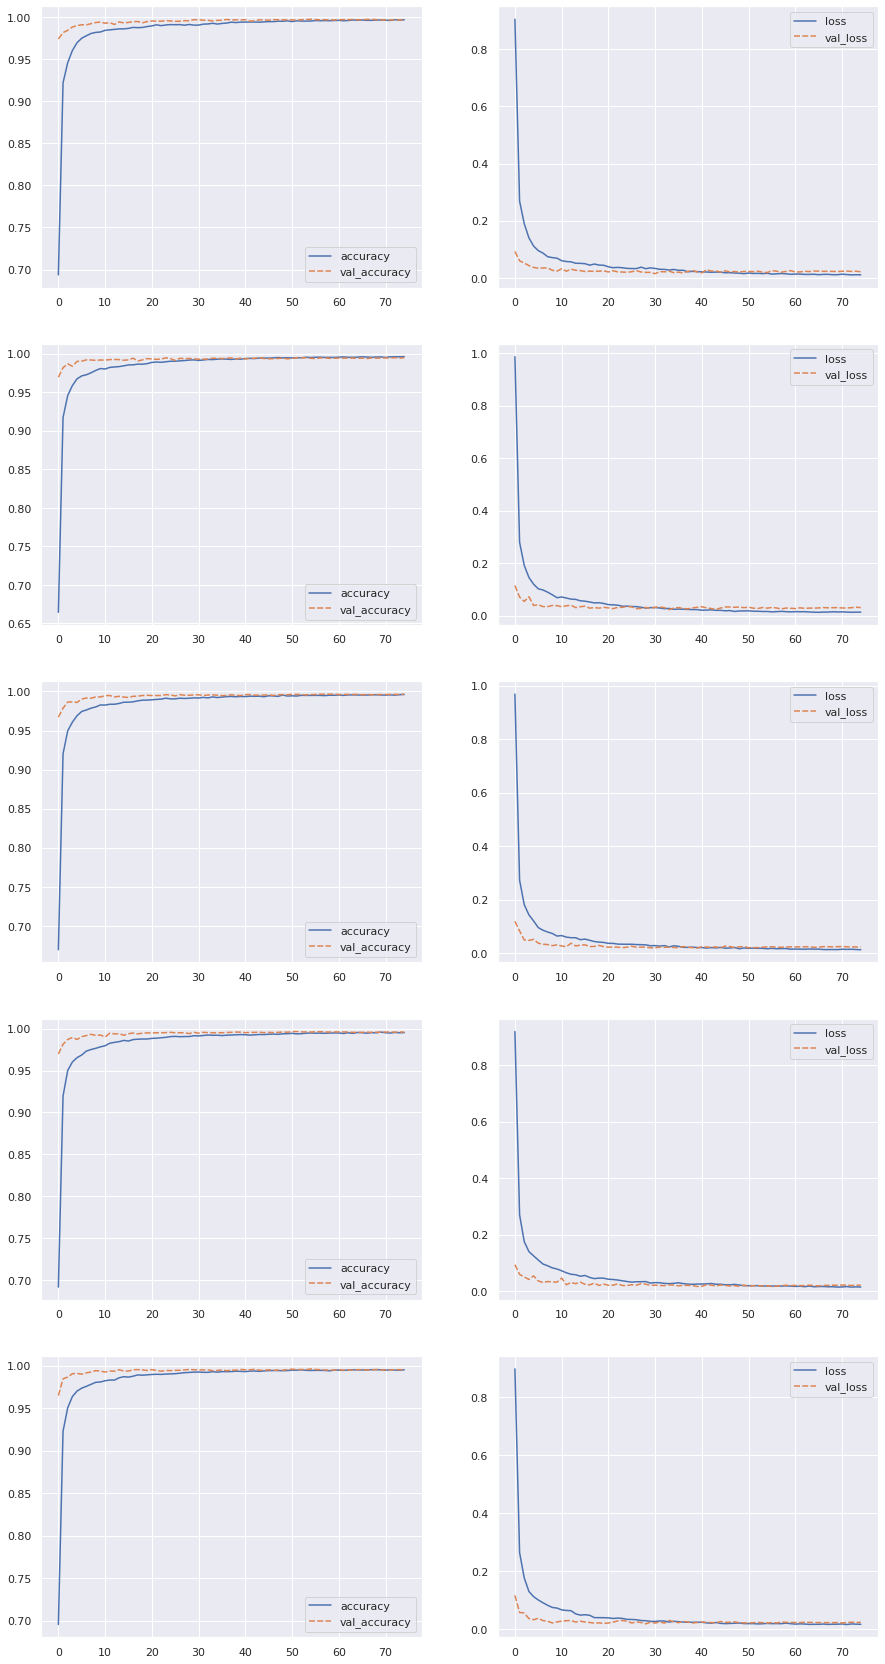

In [19]:
plt.figure(figsize=(15,6*n_models))

for i, history in enumerate(histories):
    plt.subplot(n_models, 2, 2*i+1)
    sns.lineplot(data=history[["accuracy", "val_accuracy"]])

    plt.subplot(n_models, 2, 2*i+2)
    sns.lineplot(data=history[["loss", "val_loss"]])

plt.show()

## 💯 Evaluating Results

In [20]:
def predict_classes(model, x):
    return np.argmax(model.predict(x), axis=1)

def ensembled_predict_classes(models, data_x):
    predictions = np.zeros((data_x.shape[0], 10))
    for model in models:
        predictions = predictions + model.predict(data_x)
    return np.argmax(predictions, axis=1)

In [21]:
from sklearn.metrics import accuracy_score

def evaluate(model, model_name=None):
    if model_name:
        print_title(f"Model {i+1}")
    
    print("Evaluating on Training Data...", end=" ")
    train_accuracy = accuracy_score(predict_classes(model, train_images), train_labels)
    print(f"Done.")
    print("Evaluating on Testing Data...", end=" ")
    test_accuracy = accuracy_score(predict_classes(model, test_images), test_labels)
    print(f"Done.\n")

    print(f"Train Accuracy: {train_accuracy}\nTest Accuracy: {test_accuracy}\n")

def ensembled_evaluate(models, title=None):
    print_title(title if title else "Ensembled")

    print("Evaluating on Training Data...", end=" ")
    train_accuracy = accuracy_score(ensembled_predict_classes(models, train_images), train_labels)
    print(f"Done.")
    print("Evaluating on Testing Data...", end=" ")
    test_accuracy = accuracy_score(ensembled_predict_classes(models, test_images), test_labels)
    print(f"Done.\n")

    print(f"Train Accuracy: {train_accuracy}\nTest Accuracy: {test_accuracy}\n")

In [22]:
for i, model in enumerate(models):
    evaluate(model, f"Model {i+1}")


--------------------------------------------------
Model 1
--------------------------------------------------

Evaluating on Training Data... Done.
Evaluating on Testing Data... Done.

Train Accuracy: 0.9993166666666666
Test Accuracy: 0.9964


--------------------------------------------------
Model 2
--------------------------------------------------

Evaluating on Training Data... Done.
Evaluating on Testing Data... Done.

Train Accuracy: 0.99905
Test Accuracy: 0.9969


--------------------------------------------------
Model 3
--------------------------------------------------

Evaluating on Training Data... Done.
Evaluating on Testing Data... Done.

Train Accuracy: 0.9992
Test Accuracy: 0.9966


--------------------------------------------------
Model 4
--------------------------------------------------

Evaluating on Training Data... Done.
Evaluating on Testing Data... Done.

Train Accuracy: 0.9991666666666666
Test Accuracy: 0.9961


----------------------------------------------

In [23]:
ensembled_evaluate(models)


--------------------------------------------------
Ensembled
--------------------------------------------------

Evaluating on Training Data... Done.
Evaluating on Testing Data... Done.

Train Accuracy: 0.9995
Test Accuracy: 0.9971

